In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../wanpy")

from wanpy import *
from pythtb import *
from wpythtb import *
import models
import numpy as np
import matplotlib.pyplot as plt

/Users/treycole/Repos/WanPy/tutorials


# Haldane model

Setting up `pythTB` tight-binding model for the Haldane model parameterized by the onsite potential $\Delta$, nearest neighbor hopping $t_1$ and complex next nearest neighbor hopping $t_2$

In [2]:
# tight-binding parameters
delta = t1 = 1
t2 = -0.1
n_super_cell = 2  # number of primitive cells along both lattice vectors

model = models.Haldane(delta, t1, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

# `Wannier` class

The `Wannier`class contains the functions relevant for subspace selection, maximal-localization, and Wannier interpolation. We initialize it by passing the reference `Model` and number of k-points along each dimension in the mesh.

In [3]:
nks = 20, 20  # number of k points along each dimension
WF = Wannier(model, nks)

Each `Wannier` instance has the following attributes 
- `model`: reference to the `Model`
- `K_mesh`: a `K_mesh` instance on which the Bloch eigenstates are defined
- `supercell`: a list of tuples defining the supercell conjugate to the discrete k-mesh
- `energy_eigstates`: a `Bloch` instance containing the energy eigenstates
-  `tilde_states`: a `Bloch` instance containing the Bloch-like states corresponding to the Wannier functions.

In [4]:
from pprint import pprint
pprint(list(vars(WF).keys()))

['model', '_nks', 'k_mesh', 'energy_eigstates', 'tilde_states', 'supercell']


## Setting up trial wavefunctions 

Now we must choose trial wavefunctions to construct our Bloch-like states. A natural choice is delta functions on the low-energy sublattice in the home cell. 

The trial wavefunctions are defined by lists of tuples specifying the trial wavefunction's probability amplitude over the orbitals `[(n, c_n), ...]`. 

$$ |t_i \ \rangle = \sum_n c_n |\phi_n\rangle $$


_Note_: Normalization is handled internally so the square of the amplitudes do not need to sum to $1$. Any orbitals not specified are taken to have zero amplitude.

In [5]:
# model specific constants
n_orb = model.get_num_orbitals()  # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)
low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers

# defining the trial wavefunctions
tf_list = [ [(orb, 1)] for orb in low_E_sites]
n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

Trial wavefunctions: [[(np.int64(0), 1)], [(np.int64(2), 1)], [(np.int64(4), 1)], [(np.int64(6), 1)]]
# of Wannier functions: 4
# of occupied bands: 4
Wannier fraction: 1.0


In [6]:
WF.set_trial_wfs(tf_list)
WF.trial_wfs

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]])

In [7]:
WF.n_twfs

4

## Projection step

To obtain the initial Bloch-like states from projection we call the method `single_shot` providing the trial wavefunctions we specified and the band-indices to construct Wannier functions from. This performs the operations,
1. Projection $$ (A_{\mathbf{k}})_{mn} = \langle \psi_{m\mathbf{k}} | t_n \rangle$$
2. SVD $$ A_{\mathbf{k}} = V_{\mathbf{k}} \Sigma_{\mathbf{k}} W_{\mathbf{k}}^{\dagger} $$
3. Unitary rotation$$ |\tilde{\psi}_{n\mathbf{k}} \rangle = \sum_{m\in \text{band idxs}} |\psi_{m\mathbf{k}} \rangle (V_{\mathbf{k}}W_{\mathbf{k}}^{\dagger})_{mn} $$
4. Fourier transformation $$  |\mathbf{R} n\rangle = \sum_{\mathbf{k}} e^{-i\mathbf{k}\cdot \mathbf{R}} |\tilde{\psi}_{n\mathbf{k}} \rangle  $$

In [8]:
WF.single_shot(band_idxs=list(range(n_occ)))

This will already gives us quite localized Wannier functions. We can see their spreads by calling the function `report`.

In [9]:
WF.report()

Wannier function report
 --------------------- 
Quadratic spreads:
w_0 --> 0.10437
w_1 --> 0.10437
w_2 --> 0.10437
w_3 --> 0.10437
Centers:
w_0 --> [0.16667 0.16667]
w_1 --> [0.16667 0.66667]
w_2 --> [0.66667 0.16667]
w_3 --> [0.66667 0.66667]
Omega_i = 0.3723288655936301
Omega_tilde = 0.0451622119762989


We can also directly access the attributes

In [10]:
print(WF.spread)
print(WF.omega_i)
print(WF.omega_til)
print(WF.centers)

omega_til_ss = WF.omega_til

[0.10437277 0.10437277 0.10437277 0.10437277]
0.3723288655936301
0.0451622119762989
[[0.5        0.28867513]
 [1.         1.15470054]
 [1.5        0.28867513]
 [2.         1.15470054]]


We can visualize the Wannier density using `plot_density`. We specify which Wannier function to look at with `Wan_idx`.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$|\\mathbf{r}- \\mathbf{{r}}_c|$', ylabel='$|w_1(\\mathbf{r}- \\mathbf{r}_c)|^2$'>)

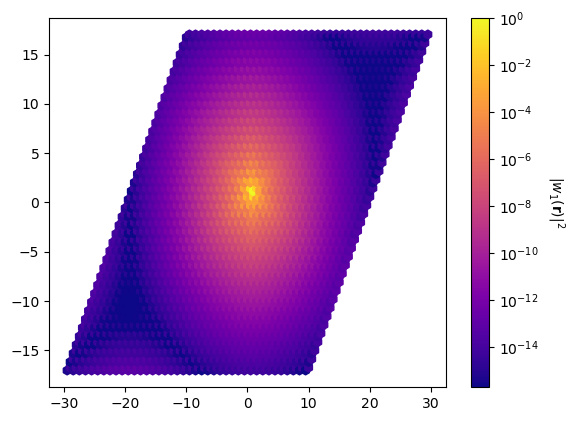

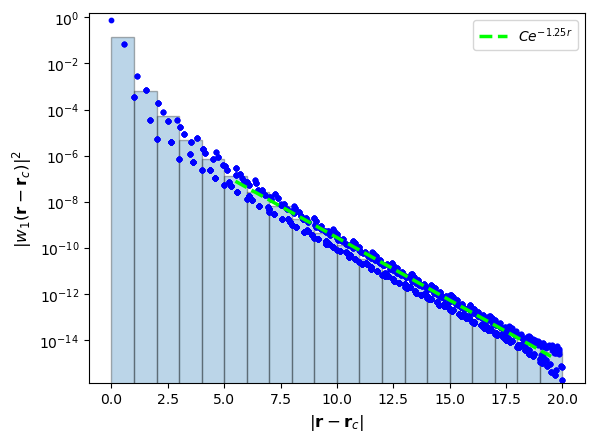

In [11]:
WF.plot_density(Wan_idx=1)
WF.plot_decay(Wan_idx=1, fit_rng=[5,20])

## Maximal Localization

_Maximal localization_ finds the optimal unitary rotation that minimizes the gauge dependent spread $\widetilde{\Omega}$ using the Marzari-Vanderbilt algorithm from PhysRevB.56.12847. 

To do so we call the `max_loc` function, specifying the following
- `eps` is the step size for gradient descent
- `iter_num` is the number of iterations before the calculation stops
- Optionally we can set `tol` specifying the minimum change in the spread at subsequent iterations before convergence
- For additional control we specify `grad_min` which sets the minimum gradient of the spread before convergence.

In [ ]:
iter_num = 1000

WF.max_loc(eps=1e-3, iter_num=iter_num, tol=1e-10, grad_min=1e-10, verbose=True)

Now let's see how the localization improved.

In [ ]:
WF.report()

omega_til_ml = WF.omega_til
print()
print(f"Spread lowered by: {omega_til_ss-omega_til_ml}")

# Reduced Wanner functions and subspace selection

In [ ]:
# tight-binding parameters
delta = 1
t1 = 1
t2 = -0.4

n_super_cell = 2
model = models.Haldane(delta, t1, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

# model specific constants
n_orb = model.get_num_orbitals()  # number of orbitals
n_occ = int(n_orb/2)  # number of occupied bands (assume half-filling)
lat_vecs = model.get_lat()  # lattice vectors
orb_vecs = model.get_orb()  # orbital vectors

# Chern number
u_wfs_full = wf_array(model, [20, 20]) # container for wavefunctions
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)
print(f"Chern number: {chern:0.3f}")

Since the occupied manifold is obstructed, we must use restricted projection in order to Wannierize a subspace. For example, let's Wannierize a 3-dimensional subspace by choosing trial wavefunctions centered on 3 of the low energy orbitals.

In [ ]:
low_E_sites = np.arange(0, n_orb, 2)  # low-energy sites defined to be indexed by even numbers
high_E_sites = np.arange(1, n_orb, 2)  # high-energy sites defined to be indexed by odd numbers

omit_site = 6  # omitting one of the low energy sites
tf_list = list(np.setdiff1d(low_E_sites, [omit_site])) 

n_tfs = len(tf_list)

print(f"Trial wavefunctions: {tf_list}")
print(f"# of Wannier functions: {n_tfs}")
print(f"# of occupied bands: {n_occ}")
print(f"Wannier fraction: {n_tfs/n_occ}")

As before, instantiate the Wannier class and start with the initial projection

In [ ]:
nks = 20, 20  # number of k points along each dimension
WF = Wannier(model, nks)

WF.single_shot(tf_list, band_idxs=list(range(n_occ)))

## Subspace selection

Now we have an initial subspace. We can use disentanglement, or subspace selection, using the algorithm introduced in PhysRevB.65.035109 by Souza, Marzari and Vanderbilt. This allows us to obtain the subspace with the minimal gauge-independent spread $\Omega_I$.

In [ ]:
# subspace selection
WF.subspace_selec(iter_num=1000, tol=1e-10, verbose=True)

To obtain maximally localized Wannier functions, we follow this with another projection to initialize a smooth gauge, then maximal localization.
- Note we must pass the flag `tilde=True` to indicate we are projecting the trial wavefunctions onto the tilde states and not the energy eigenstates

In [ ]:
WF.single_shot(tf_list, tilde=True)
WF.max_loc(eps=1e-3, iter_num=1000, tol=1e-10, grad_min=1e-10, verbose=False)

In [ ]:
WF.report()

In [ ]:
WF.plot_density(0)
WF.plot_decay(0, fit_rng=[0,20])

## Wannier interpolation

We can view the Wannier interpolated bands by calling `plot_interp_bands`. We specify a set of high-symmetry k-points that defines the one-dimensional path along which the bands are plotted. 

In [ ]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')

# Ploting Wannier interpolated bands
fig, ax = WF.tilde_states.plot_interp_bands(
    k_path, nk=501, k_label=k_label, red_lat_idx=high_E_sites, cmap='plasma')

# Plotting actual bands for comparison
(k_vec, k_dist, k_node) = model.k_path(k_path, 501, report=False)
evals, evecs = model.solve_ham(k_vec, return_eigvecs=True)
n_eigs = evecs.shape[-2]
for n in range(evals.shape[-1]):
    ax.plot(k_dist, evals[:, n], c='k', lw=2, zorder=0, alpha=0.25)

If we like, these interpolated energies and eigenstates are also directly accesible using `interp_energies` and the optional flag `ret_eigvecs` to obtain the eigenvectors.

In [ ]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 501, report=False)

# Reduced Wannier interpolated energies and states
interp_energies, interp_unk = WF.interp_energies(k_vec, ret_eigvecs=True)